# PROJECT LAYOUT

#### In this notebook, we aim to explore and implement two forecasting methods to predict future electricity production. To achieve this, we will evaluate and compare the performance of:

- SARIMAX
- LSTM



In [322]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

from prophet import Prophet
from prophet.plot import plot_plotly

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import mean_squared_error
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

import plotly.graph_objects as go


import warnings
warnings.filterwarnings("ignore")

In [323]:
df = pd.read_csv('Electric_Production.csv',parse_dates = [0])
df.head()

,DATE,Value
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


In [324]:
new_columns = ['Date', 'Production']  # Replace with your desired column names

df.columns = new_columns

In [325]:
# Set "date" to be the index
df.set_index('Date',inplace=True)
df.index.freq = 'MS'
df.index = pd.to_datetime(df.index)

df.head()

,Production
Date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


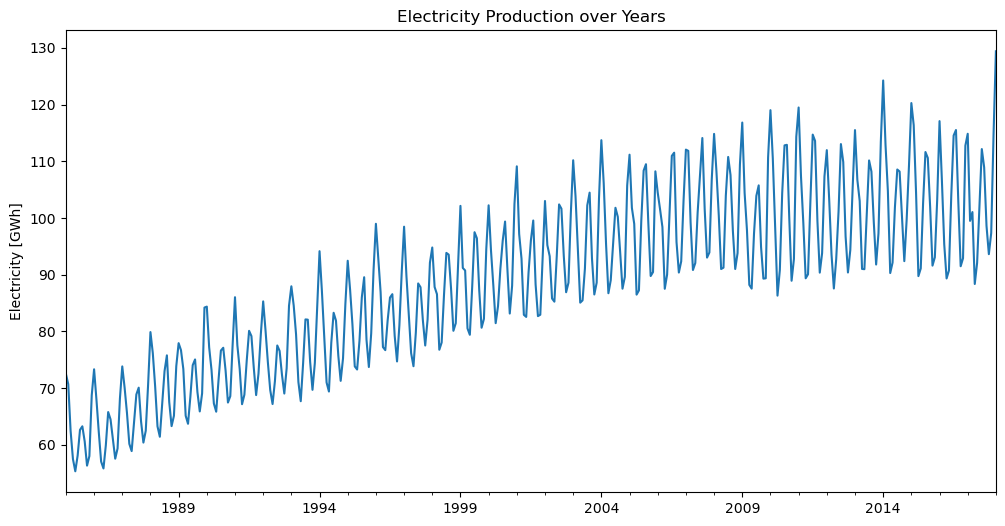

In [326]:
title = 'Electricity Production over Years'
ylabel='Electricity [GWh]'
xlabel=''

ax = df['Production'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

# Run an ETS Decomposition

We apply an additive model when it seems that the trend is more linear and the seasonality and trend components seem to be constant over time (e.g. every year we generate approx 75 GWh).
A multiplicative model is more appropriate when we are increasing (or decreasing) at a non-linear rate (e.g. each year we double the energy).

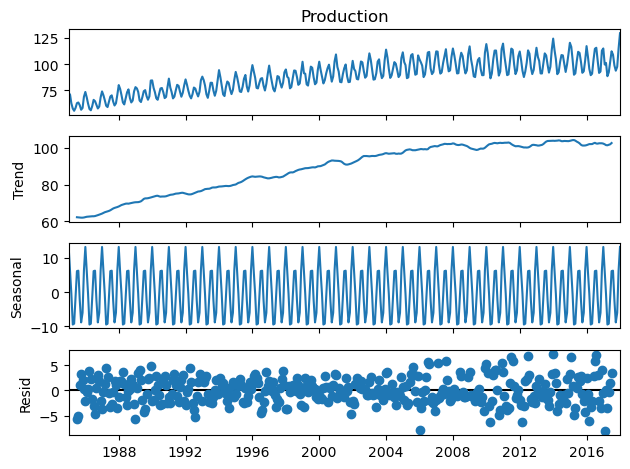

In [327]:
result = seasonal_decompose(df['Production'], model = 'add')
result.plot();

It can be seen that:

- Trend is highly positive
- Seasonality is showing that every year there is a situation that small spike is followed with bigger spike
- Residuals are randomly distributed around zero, indicating that the model has captured the main patterns in the data

# Run pmdarima.auto_arima to obtain recommended order

For SARIMA Orders we set seasonal=True, because data is prooved to be seasonal from ETS decomposition. Then pass in an m value, which is the length of a seasonal period, meaning the number of data points in each period. For our case since its annual cycles its best to put 12 for 12 months.

Below command calulates a best parameters fit for current dataset, eg. SARIMAX(1, 1, 2)x(1, 0, [1], 12)


In [328]:
auto_arima(df['Production'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  397
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -926.400
Date:                              Thu, 25 Jul 2024   AIC                           1866.799
Time:                                      14:54:09   BIC                           1894.669
Sample:                                  01-01-1985   HQIC                          1877.840
                                       - 01-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.441      0.659      -0.002       0.003
ar.L1          0.3465      0.089      3.882      0.000       0.172       0.521
ma.L1         -0.7126      0.087     -8.171      0.000      -0.884      -0.542
ma.L2         -0.2317      0.078     -2.984      0.003      -0.384      -0.080
ar.S.L12       0.9921      0.005    187.642      0.000       0.982       1.002
ma.S.L12      -0.7337      0.042    -17.437      0.000      -0.816      -0.651
sigma2         5.8660      0.338     17.375      0.000       5.204       6.528
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                25.97
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               2.92   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Splitting the data into train/test set

In [329]:
print(len(df))

397


In [330]:

A = int(len(df)*0.8) #picking 80% of data for the training purpose, and remaning for testing

train = df[:A] # 80% of dataset
test = df[A:] # 20% of dataset

# Fit a SARIMA model

In [331]:
model = SARIMAX(train['Production'],order=(1,1,2),seasonal_order=(1,0,1,12))

result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           Production   No. Observations:                  317
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -711.112
Date:                              Thu, 25 Jul 2024   AIC                           1434.224
Time:                                      14:54:10   BIC                           1456.759
Sample:                                  01-01-1985   HQIC                          1443.227
                                       - 05-01-2011                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2719      0.116      2.335      0.020       0.044       0.500
ma.L1         -0.6441      0.113     -5.683      0.000      -0.866      -0.422
ma.L2         -0.2823      0.099     -2.854      0.004      -0.476      -0.088
ar.S.L12       0.9947      0.004    241.996      0.000       0.987       1.003
ma.S.L12      -0.7174      0.049    -14.781      0.000      -0.813      -0.622
sigma2         4.7330      0.291     16.243      0.000       4.162       5.304
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                43.26
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               2.60   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [332]:
# Extract model parameters
model_order = result.model.order
seasonal_order = result.model.seasonal_order
model_info = f"SARIMAX(order={model_order}, seasonal_order={seasonal_order})"

In [333]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1 # index position corresponding to the end of the testing set. It ensures that predictions cover the entire length of the test period
predictions = result.predict(start=start, end=end, dynamic=False, typ='levels').rename(model_info)

dynamic=

False: (Static Forecasting) Predictions use the actual past values up to the forecast point and do not incorporate forecasted values as inputs for future forecasts

True: (Dynamic Forecasting) Predictions use forecasted values as inputs for future forecasts, which means errors in the forecast can propagate

Passing <tt>typ='levels'</tt> predicts the levels of the original endogenous variables. If we'd used the default <tt>typ='linear'</tt> we would have seen linear predictions in terms of the differenced endogenous variables.

For more information on these arguments visit https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

In [334]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Production'][i]}")

predicted=101.8173314, expected=102.8204
predicted=110.1385352, expected=114.7068
predicted=111.1068319, expected=113.5958
predicted=99.9208718 , expected=99.4712
predicted=92.15478541, expected=90.3566
predicted=94.2154539 , expected=93.8095
predicted=111.5111917, expected=107.3312
predicted=118.0056118, expected=111.9646
predicted=109.2301191, expected=103.3679
predicted=100.9082941, expected=93.5772
predicted=90.98823535, expected=87.5566
predicted=92.3356643 , expected=92.7603
predicted=103.2924513, expected=101.14
predicted=111.0456539, expected=113.0357
predicted=111.8663664, expected=109.8601
predicted=100.7009824, expected=96.7431
predicted=92.96554111, expected=90.3805
predicted=95.01241965, expected=94.3417
predicted=112.2156732, expected=105.2722
predicted=118.6754469, expected=115.501
predicted=109.946426 , expected=106.734
predicted=101.6687094, expected=102.9948
predicted=91.8012445 , expected=91.0092
predicted=93.14152796, expected=90.9634
predicted=104.0402196, expected

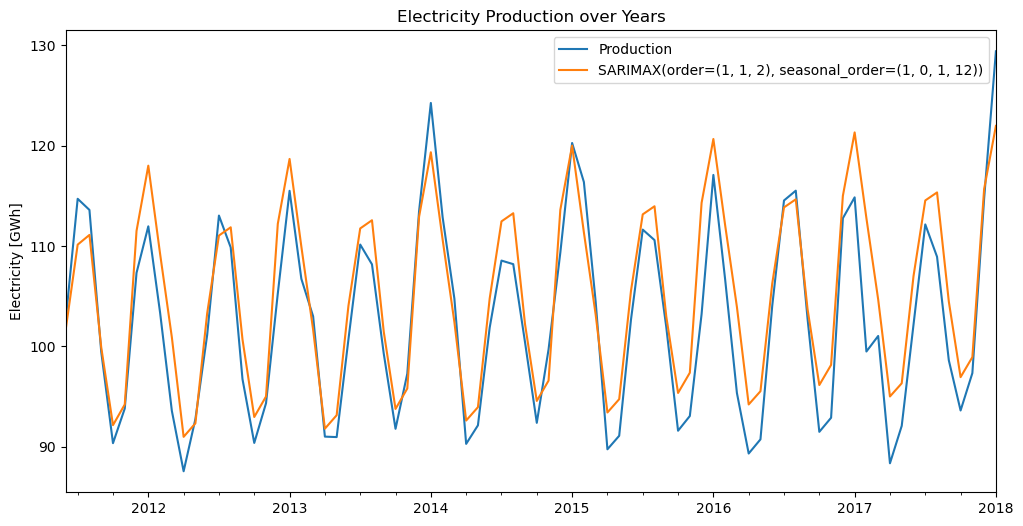

In [335]:
# Plot predictions against known values
title = 'Electricity Production over Years'
ylabel='Electricity [GWh]'
xlabel='' # we don't really need a label here

ax = test['Production'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);


# Evaluate the Model

In [336]:

mse = mean_squared_error(test['Production'], predictions)

In [337]:
print(model_info + f' MSE Error: {round(mse,2)}')


SARIMAX(order=(1, 1, 2), seasonal_order=(1, 0, 1, 12)) MSE Error: 17.42


In [338]:
from statsmodels.tools.eval_measures import rmse

rmse = rmse(test['Production'], predictions)

In [339]:
print(model_info + f' RMSE Error: {round(rmse,2)}')
print("On average, this model predictions are off by about", round(rmse, 2), "GWh")

SARIMAX(order=(1, 1, 2), seasonal_order=(1, 0, 1, 12)) RMSE Error: 4.17
On average, this model predictions are off by about 4.17 GWh


# Perform Forecast

To Plot the forecast we are using the result from fitting the model. Prediction is made for the start and end. At the end we add 120 rows correspodning to 12 years

In [340]:
#model = SARIMAX(df['Production'],order=(1,1,2),seasonal_order=(1,0,1,12))
#result = model.fit()
fcast = result.predict(start=len(df),end=len(df)+36,typ='levels').rename(model_info + ' Forecast')


Plotting the forecast

<Axes: xlabel='Date'>

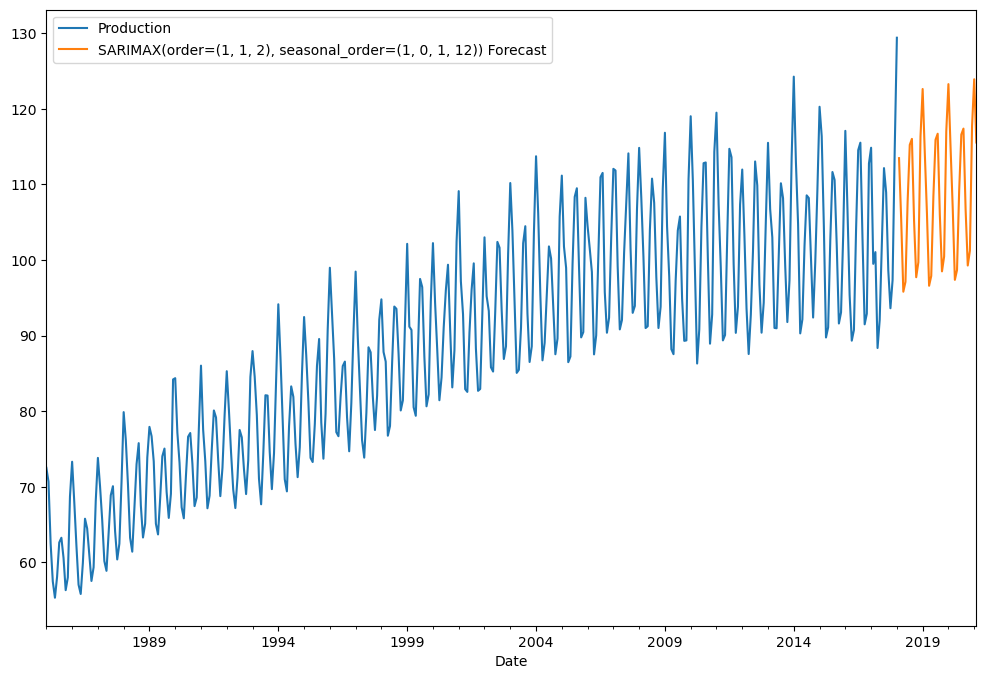

In [341]:
df['Production'].plot(legend=True, figsize=(12,8))
fcast.plot(legend=True)

# LSTM

In [231]:
df_2 = df.copy()

In [232]:
print(len(df_2))

397


In [233]:
y = df_2.values.reshape(-1, 1)

In [234]:
# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

In [346]:
# generate the input and output sequences, this will initiate following eg. it will look at past 72 observations to predict next 24
n_lookback = 72  # length of input sequences (lookback period)
n_forecast = 36  # length of output sequences (forecast period)

In [347]:
#initialize empty lists
X = []
Y = []

#create loop to make input and output sequence based on initial sequence from cell above, then convert to np array
for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

In [348]:
# Define a custom callback to track MSE
class MSECallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        mse = logs.get('loss')
        print(f'Epoch {epoch + 1} MSE: {mse:.10f}')

# Fit the model with the custom callback
model = Sequential() # initialize a new model object, which is the simplest type of model in Keras

model.add(LSTM(units=150, # number of units (neurons) in the LSTM layer
                return_sequences=True, #allows the next LSTM layer to receive a sequence of outputs applicable when stacking LSTM layers
                  input_shape=(n_lookback, 1))) # shape of the input data, 1 is the number of features per timestep


model.add(LSTM(units=150)) #second layer with same neurons and default settings 'False'
model.add(Dense(n_forecast)) #it helps the network learn complex, non-linear relationships

model.compile(loss='mean_squared_error', optimizer='adam')

mse_callback = MSECallback()  # Create an instance of the custom callback
model.fit(X, Y,
          epochs=20, #number of times the entire training dataset is passing thru the model
          batch_size=1, #by default 32, number of samples processed before updating it
          verbose=0, #mode for displaying progress during training, set to 0 which means silent
          callbacks=[mse_callback]) #logging metrics

Epoch 1 MSE: 0.0197622571
Epoch 2 MSE: 0.0142255751
Epoch 3 MSE: 0.0135605894
Epoch 4 MSE: 0.0138021549
Epoch 5 MSE: 0.0129397586
Epoch 6 MSE: 0.0043508671
Epoch 7 MSE: 0.0033818667
Epoch 8 MSE: 0.0031172284
Epoch 9 MSE: 0.0031810962
Epoch 10 MSE: 0.0030134988
Epoch 11 MSE: 0.0029510143
Epoch 12 MSE: 0.0029954098
Epoch 13 MSE: 0.0028788229
Epoch 14 MSE: 0.0026428779
Epoch 15 MSE: 0.0022562097
Epoch 16 MSE: 0.0021629038
Epoch 17 MSE: 0.0019546652
Epoch 18 MSE: 0.0020281698
Epoch 19 MSE: 0.0019750074
Epoch 20 MSE: 0.0020086893


In [349]:
# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

1/1 [==============================] - 1s 894ms/step


In [350]:
# organize the results in a data frame
df_past = df.reset_index()
df_past.rename(columns={'index': 'Date', 'Production': 'Actual Production'}, inplace=True)
df_past['Production'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual Production'].iloc[-1]

In [400]:
last_date = df_past['Date'].iloc[-1]
to_forecast = n_forecast  # number of months to forecast based on prior input


df_future = pd.DataFrame(columns=['Date', 'Actual Production', 'Forecast'])

#creates future values as for months, if you want to have days hours etc. you need to specify
df_future['Date'] = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=to_forecast, freq='M')

#specifies that each offset should be month end
df_future['Date'] = df_future['Date'] + pd.offsets.MonthBegin(0)
df_future['Forecast'] = Y_.flatten()
df_future['Actual Production'] = np.nan

In [398]:
results = df_past.append(df_future).set_index('Date')

In [399]:
results.drop('Production', axis=1, inplace = True)
results

,Actual Production,Forecast
Date,,
1985-01-01,72.5052,NaN
1985-02-01,70.6720,NaN
1985-03-01,62.4502,NaN
1985-04-01,57.4714,NaN
1985-05-01,55.3151,NaN
...,...,...
2020-10-01,NaN,101.565300
2020-11-01,NaN,93.753387
2020-12-01,NaN,99.703613


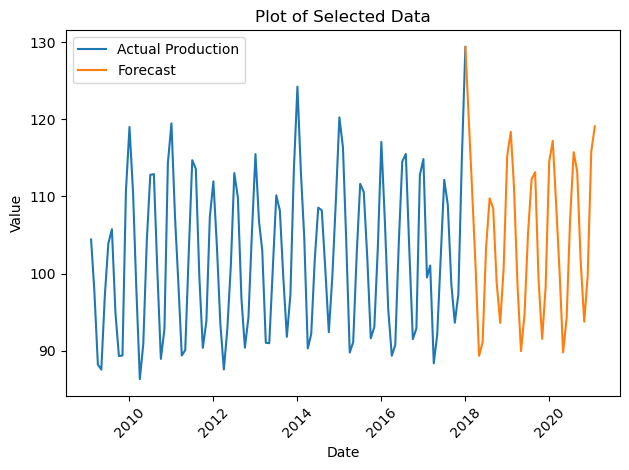

In [354]:
#assign start and end date of your graph
start_date = '2009-01-31'
end_date = '2021-02-01'
selected_data = results.loc[start_date:end_date]

plt.plot(selected_data)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Plot of Selected Data')
plt.legend(selected_data.columns)

# Adjust x-axis tick labels and make a tight layout
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [395]:
#Preparing dataframe with predictions only for following figure
forecastdf = pd.DataFrame(fcast).reset_index()
selected_data_df = selected_data.reset_index()

result = pd.merge(forecastdf, selected_data_df, left_index=True, right_index=True)
result = result.drop(columns=["Date","Actual Production"]).rename(columns={"index":"Date"})
result.set_index('Date', inplace=True)

In [401]:
result

,"SARIMAX(order=(1, 1, 2), seasonal_order=(1, 0, 1, 12)) Forecast",Forecast
Date,,
2018-02-01,113.471285,111.000771
2018-03-01,105.410704,100.777550
2018-04-01,95.802077,89.327950
2018-05-01,97.107203,91.068558
2018-06-01,107.720007,103.344292
2018-07-01,115.229801,109.764412
2018-08-01,116.024748,108.466324
2018-09-01,105.209895,98.853020
2018-10-01,97.717304,93.594360


In [413]:

# initialize figure
fig = go.Figure()

# add traces for each series
fig.add_trace(go.Scatter(x=df.index, y=df['Production'], mode='lines', name='Production'))
fig.add_trace(go.Scatter(x=result.index, y=result['Forecast'], mode='lines', name='LSTM Forecast'))
fig.add_trace(go.Scatter(x=result.index, y=result['SARIMAX(order=(1, 1, 2), seasonal_order=(1, 0, 1, 12)) Forecast'], mode='lines', name='SARIMAX Forecast'))

# create layout
fig.update_layout(
    title='Methods Comparison',
    xaxis_title='Date',
    yaxis_title='Value',
    legend_title='Legend'
)

# show the plot
fig.show()